In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
plt.rcParams["font.sans-serif"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False

def build_facebook_graph(network_file):
    G = nx.read_edgelist(
        network_file,
        create_using=nx.Graph(),
        nodetype=int,
        data=[('weight', int)]
    )

    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
    node_degrees = np.array([G.degree(node) for node in range(G.number_of_nodes())])
    
    print(f"Facebook网络基本信息:")
    print(f"- 节点数: {G.number_of_nodes()}")
    print(f"- 边数: {G.number_of_edges()}")
    print(f"- 平均节点度: {np.mean([d for _, d in G.degree()]):.2f}")
    print(f"- 网络密度: {nx.density(G):.6f}")
    print(f"- 连通分量数: {nx.number_connected_components(G)}")
    print(f"- 平均最短距离: {np.mean(average_path_lengths):.2f}")
    
    return G, node_degrees

network_file = 'facebook_combined.txt'
G, node_degrees = build_facebook_graph(network_file)

Facebook网络基本信息:
- 节点数: 4039
- 边数: 88234
- 平均节点度: 43.69
- 网络密度: 0.010820
- 连通分量数: 1
- 平均最短距离: 3.69


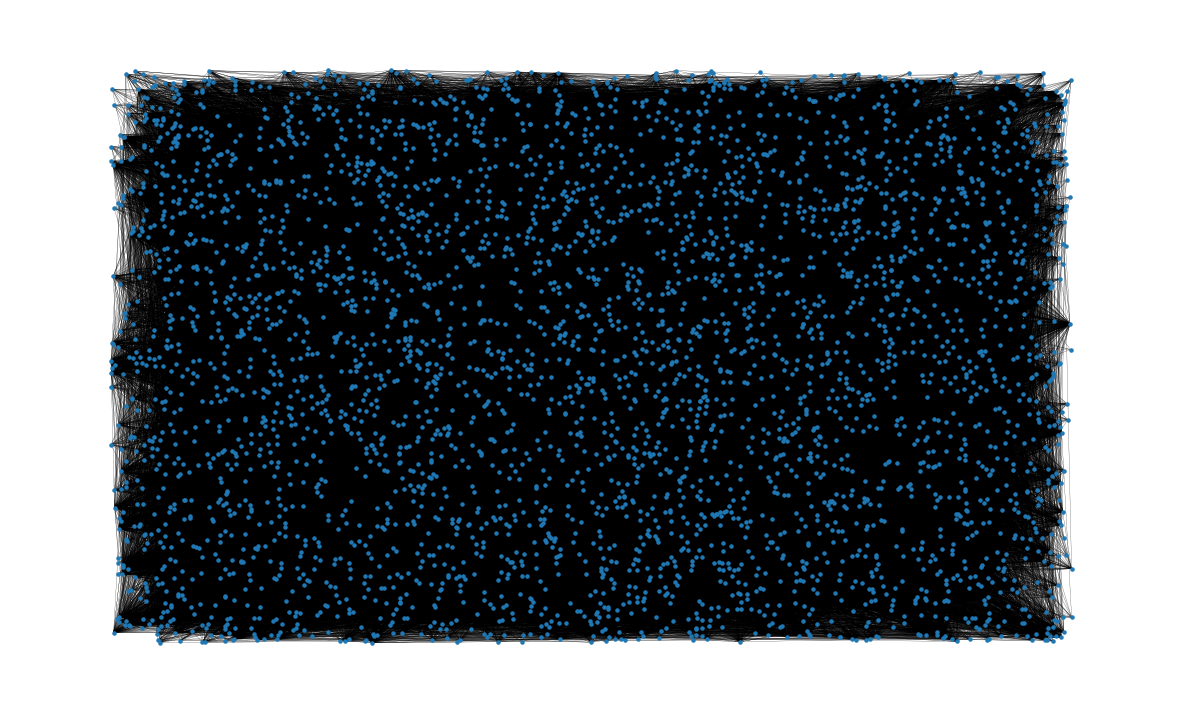

In [2]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")#关闭所有坐标轴线、刻度标记和标签
plot_options = {"node_size": 5, "with_labels": False, "width": 0.15}
nx.draw(G, pos=nx.random_layout(G), ax=ax, **plot_options)

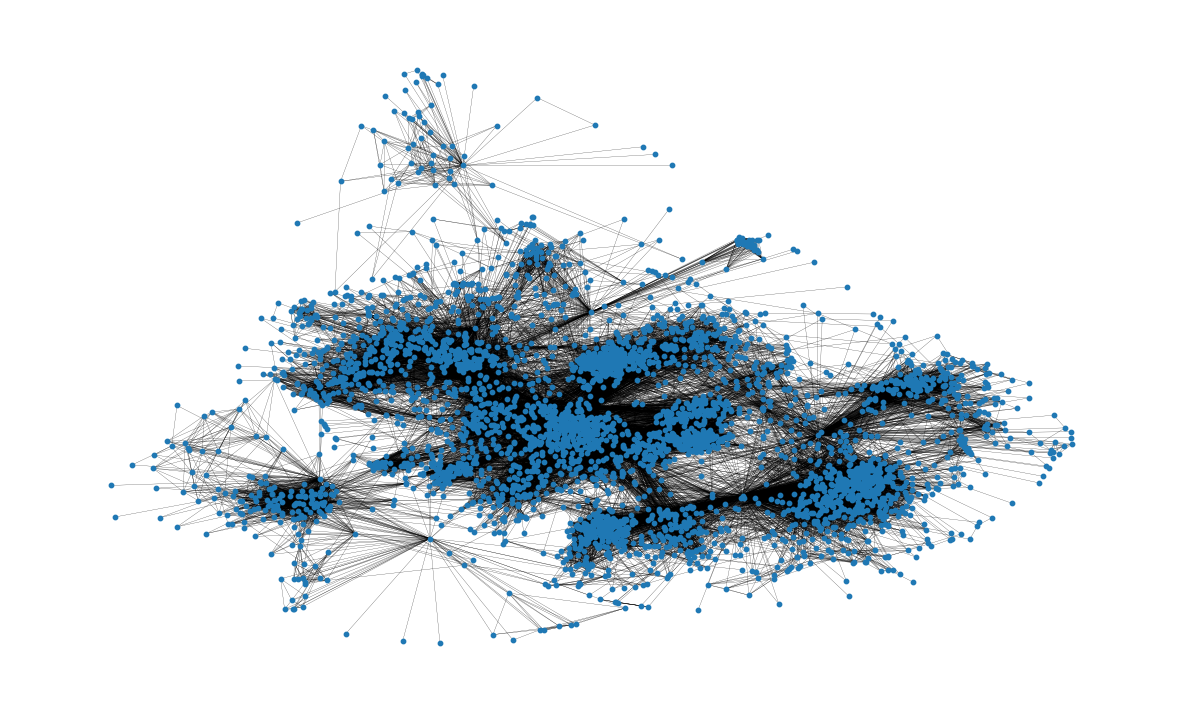

In [6]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1800)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [4]:
def train_node2vec_embedding(G, embed_dim=20, walk_length=30, num_walks=200):
    print(f"\n开始训练Node2Vec嵌入（维度={embed_dim}，游走步数={walk_length}，轮次={num_walks}）...")
    node2vec = Node2Vec(
        G,
        dimensions=embed_dim,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=4,
        p=2,
        q=1
    )

    model = node2vec.fit(window=10, min_count=1, batch_words=1000)

    node_embeddings = []
    for node_id in range(G.number_of_nodes()):
        node_embeddings.append(model.wv[str(node_id)])

    node_embeddings = np.array(node_embeddings)
    print(f"Node2Vec嵌入完成{node_embeddings.shape}")
    
    return node_embeddings

embed_dim = 20
node_embeddings = train_node2vec_embedding(G, embed_dim=embed_dim)


开始训练Node2Vec嵌入（维度=20，游走步数=30，轮次=200）...


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Node2Vec嵌入完成(4039, 20)


K=2: WCSS=2084.69, 轮廓系数=0.1463
K=3: WCSS=1800.00, 轮廓系数=0.2073
K=4: WCSS=1531.20, 轮廓系数=0.2642
K=5: WCSS=1323.57, 轮廓系数=0.3092
K=6: WCSS=1172.76, 轮廓系数=0.3418
K=7: WCSS=1040.96, 轮廓系数=0.3539
K=8: WCSS=981.03, 轮廓系数=0.3242
K=9: WCSS=922.89, 轮廓系数=0.3150
K=10: WCSS=865.70, 轮廓系数=0.3079
肘部法则推荐K值: 3
轮廓系数推荐K值: 7
最终最优K值: 7


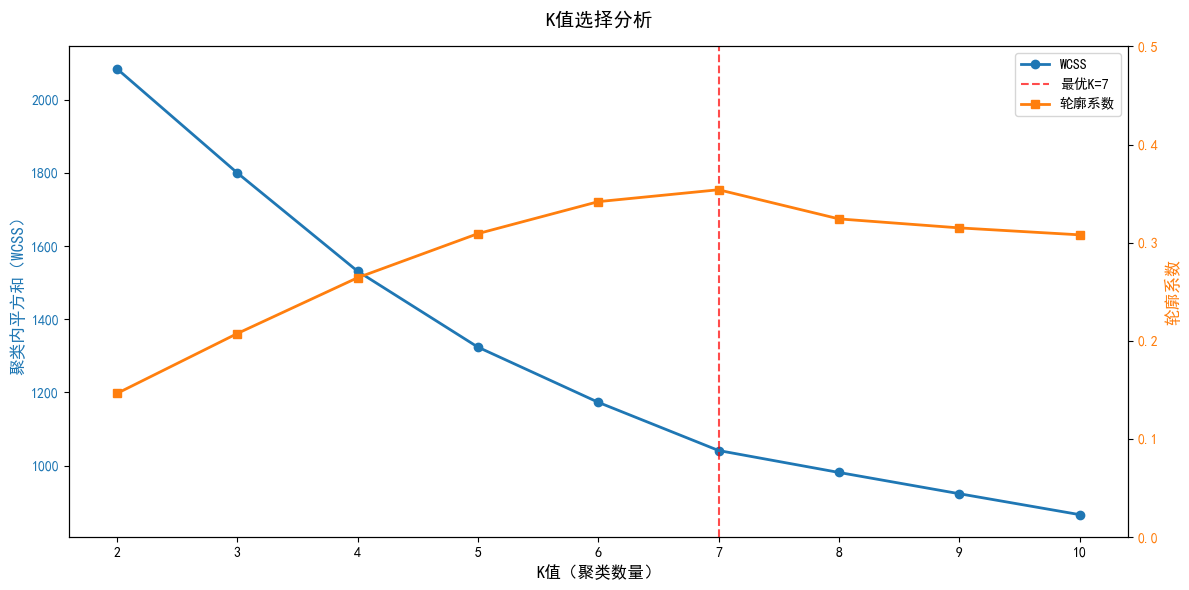

In [7]:
def optimize_k_selection(node_embeddings, k_range=range(2, 8)):
    scaler = MinMaxScaler()
    node_embeddings_scaled = scaler.fit_transform(node_embeddings)
    
    wcss_list = []
    silhouette_list = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(node_embeddings_scaled)

        wcss = kmeans.inertia_
        wcss_list.append(wcss)
        
        if k > 1:
            silhouette_avg = silhouette_score(node_embeddings_scaled, cluster_labels)
            silhouette_list.append(silhouette_avg)
        else:
            silhouette_list.append(0)

        print(f"K={k}: WCSS={wcss:.2f}, 轮廓系数={silhouette_avg:.4f}")
    
    wcss_diff = np.diff(wcss_list)
    elbow_k = k_range[np.argmin(wcss_diff) + 1]

    max_silhouette_k = k_range[np.argmax(silhouette_list)]

    if abs(elbow_k - max_silhouette_k) <= 1:
        optimal_k = max_silhouette_k
    else:
        optimal_k = max_silhouette_k
    
    print(f"肘部法则推荐K值: {elbow_k}")
    print(f"轮廓系数推荐K值: {max_silhouette_k}")
    print(f"最终最优K值: {optimal_k}")

    plot_k_selection_analysis(k_range, wcss_list, silhouette_list, optimal_k)
    
    return optimal_k, wcss_list, silhouette_list

def plot_k_selection_analysis(k_range, wcss_list, silhouette_list, optimal_k):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color1 = '#1f77b4'
    ax1.set_xlabel('K值（聚类数量）', fontsize=12)
    ax1.set_ylabel('聚类内平方和（WCSS）', color=color1, fontsize=12)
    ax1.plot(k_range, wcss_list, 'o-', color=color1, linewidth=2, label='WCSS')
    ax1.tick_params(axis='y', labelcolor=color1)

    elbow_idx = list(k_range).index(optimal_k)
    ax1.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'最优K={optimal_k}')

    ax2 = ax1.twinx()
    color2 = '#ff7f0e'
    ax2.set_ylabel('轮廓系数', color=color2, fontsize=12)
    ax2.plot(k_range, silhouette_list, 's-', color=color2, linewidth=2, label='轮廓系数')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim(0, 0.5)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)
    
    plt.title('K值选择分析', fontsize=14, pad=15)
    plt.tight_layout()
    plt.show()

k_range = range(2, 11)
optimal_k, wcss_list, silhouette_list = optimize_k_selection(node_embeddings, k_range)

In [8]:
def kmeans_clustering(node_embeddings, n_clusters=optimal_k):
    scaler = MinMaxScaler()
    node_embeddings_scaled = scaler.fit_transform(node_embeddings)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(node_embeddings_scaled)

    unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
    print(f"聚类完成，各聚类占比: {[f'{count/len(cluster_labels):.4f}' for count in cluster_counts]}")
    
    return cluster_labels, kmeans, scaler

cluster_labels, kmeans, scaler = kmeans_clustering(node_embeddings, n_clusters=optimal_k)

聚类完成，各聚类占比: ['0.1931', '0.2525', '0.0844', '0.1864', '0.0513', '0.1349', '0.0973']


In [9]:
def analyze_cluster_meaning(cluster_labels, node_degrees, n_clusters=optimal_k):
    cluster_degree_stats = []
    
    for cluster_id in range(n_clusters):
        cluster_node_degrees = node_degrees[cluster_labels == cluster_id]
        avg_degree = np.mean(cluster_node_degrees)
        cluster_degree_stats.append({
            "cluster_id": cluster_id,
            "avg_degree": avg_degree,
            "max_degree": np.max(cluster_node_degrees),
            "min_degree": np.min(cluster_node_degrees),
            "node_count": len(cluster_node_degrees),
            "core_score": avg_degree / np.mean(node_degrees)
        })
        print(f"聚类{cluster_id}: 平均度={avg_degree:.2f}, 节点数={len(cluster_node_degrees)}")
    
    cluster_degree_stats_sorted = sorted(cluster_degree_stats, key=lambda x: x["core_score"], reverse=True)
    core_cluster_ids = [stat["cluster_id"] for stat in cluster_degree_stats_sorted]
    print(f"\n聚类核心性排序（从核心到边缘）: {core_cluster_ids}")

    return core_cluster_ids, cluster_degree_stats_sorted

node_degrees = np.array([G.degree(node) for node in range(G.number_of_nodes())])
core_cluster_ids, cluster_degree_stats = analyze_cluster_meaning(cluster_labels, node_degrees)

聚类0: 平均度=37.72, 节点数=780
聚类1: 平均度=53.84, 节点数=1020
聚类2: 平均度=16.67, 节点数=341
聚类3: 平均度=81.86, 节点数=753
聚类4: 平均度=19.22, 节点数=207
聚类5: 平均度=19.60, 节点数=545
聚类6: 平均度=25.82, 节点数=393

聚类核心性排序（从核心到边缘）: [3, 1, 0, 6, 5, 4, 2]


In [10]:
n_clusters = optimal_k
colors = plt.cm.Spectral(np.linspace(0.1, 0.9, n_clusters))
n_clusters = int(np.max(cluster_labels) + 1)
cluster_color_map = {i: colors[i] for i in range(n_clusters)}
node_colors = [cluster_color_map[cluster_labels[n]] for n in G.nodes()]

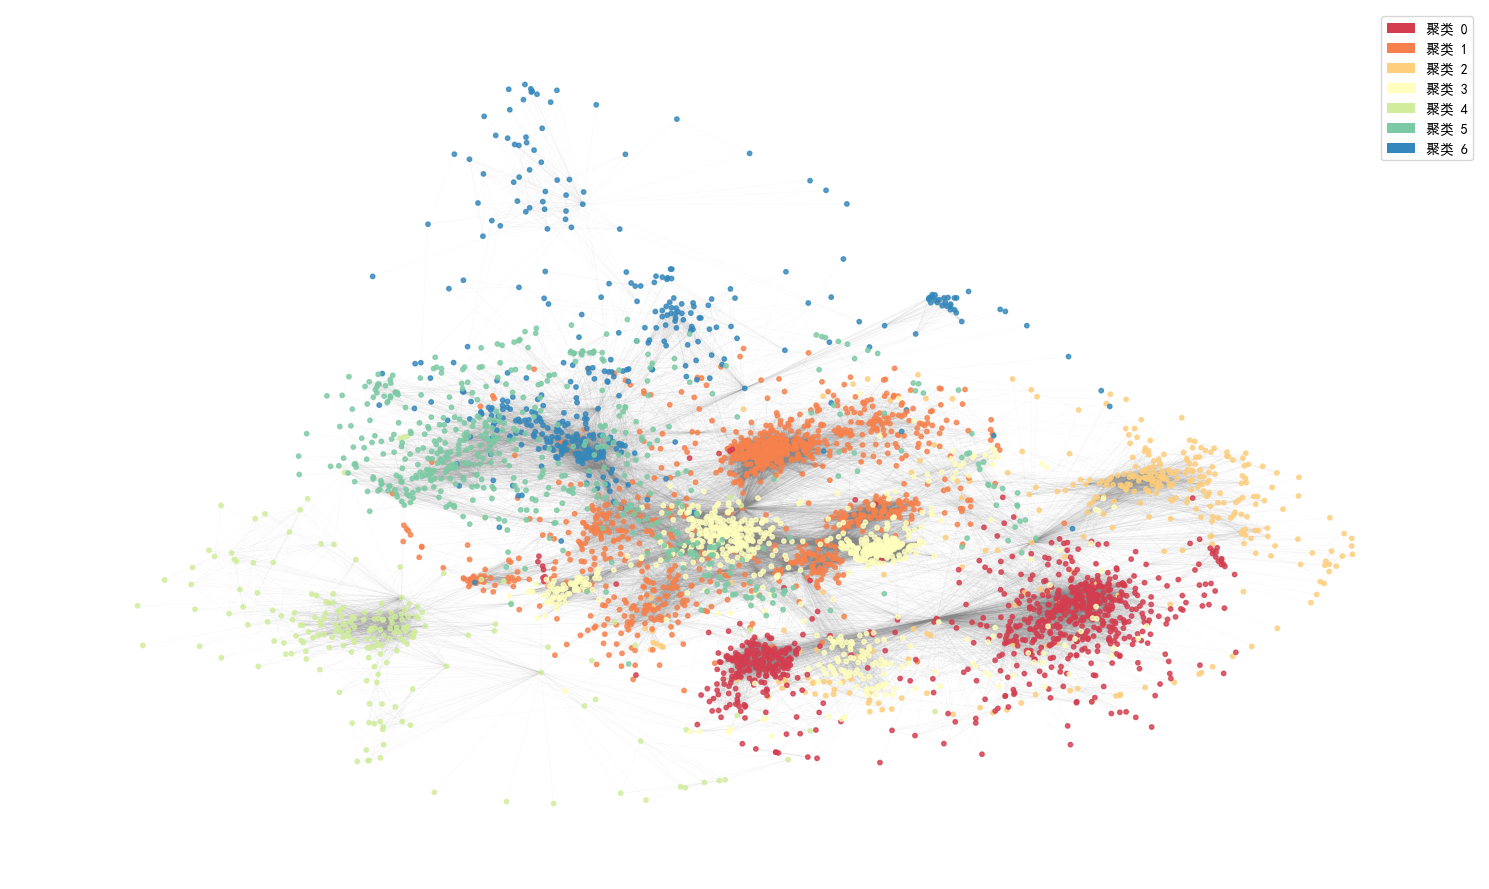

In [18]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=plot_options["node_size"], node_color=node_colors, ax=ax, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=plot_options["width"], alpha=0.15, edge_color="#888888", ax=ax)
legend_elements = [Patch(facecolor=cluster_color_map[i], label=f"聚类 {i}") for i in range(n_clusters)]
ax.legend(handles=legend_elements, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show()

Text(0, 0.5, 't-SNE维度2')

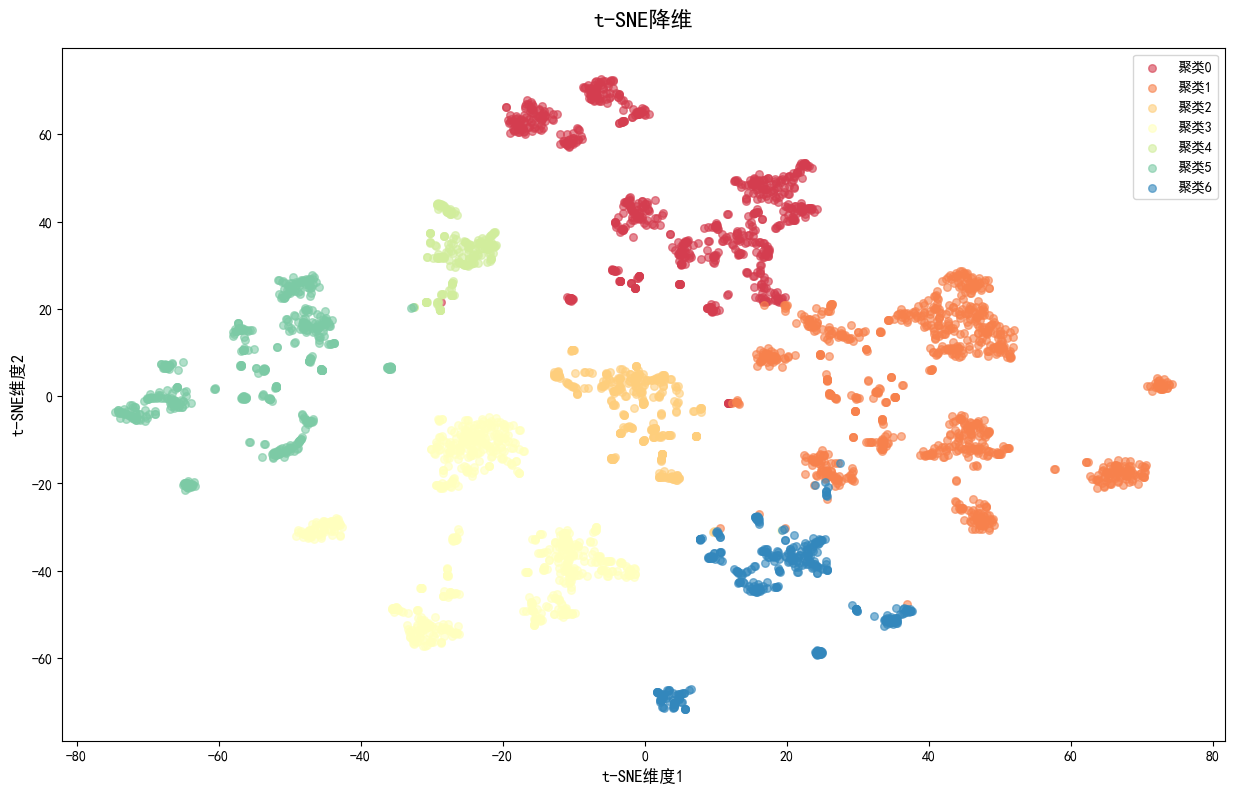

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans'] 
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(15, 9))
ax.set_title("t-SNE降维", fontsize=16, pad=15)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(node_embeddings)
for cluster_id in range(n_clusters):
    mask = cluster_labels == cluster_id
    ax.scatter(
        embeddings_tsne[mask, 0], embeddings_tsne[mask, 1],
        c=[cluster_color_map[cluster_id]],
        label=f'聚类{cluster_id}', alpha=0.6, s=30
    )
ax.legend(fontsize=10, loc='best')
ax.set_xlabel("t-SNE维度1", fontsize=12)
ax.set_ylabel("t-SNE维度2", fontsize=12)

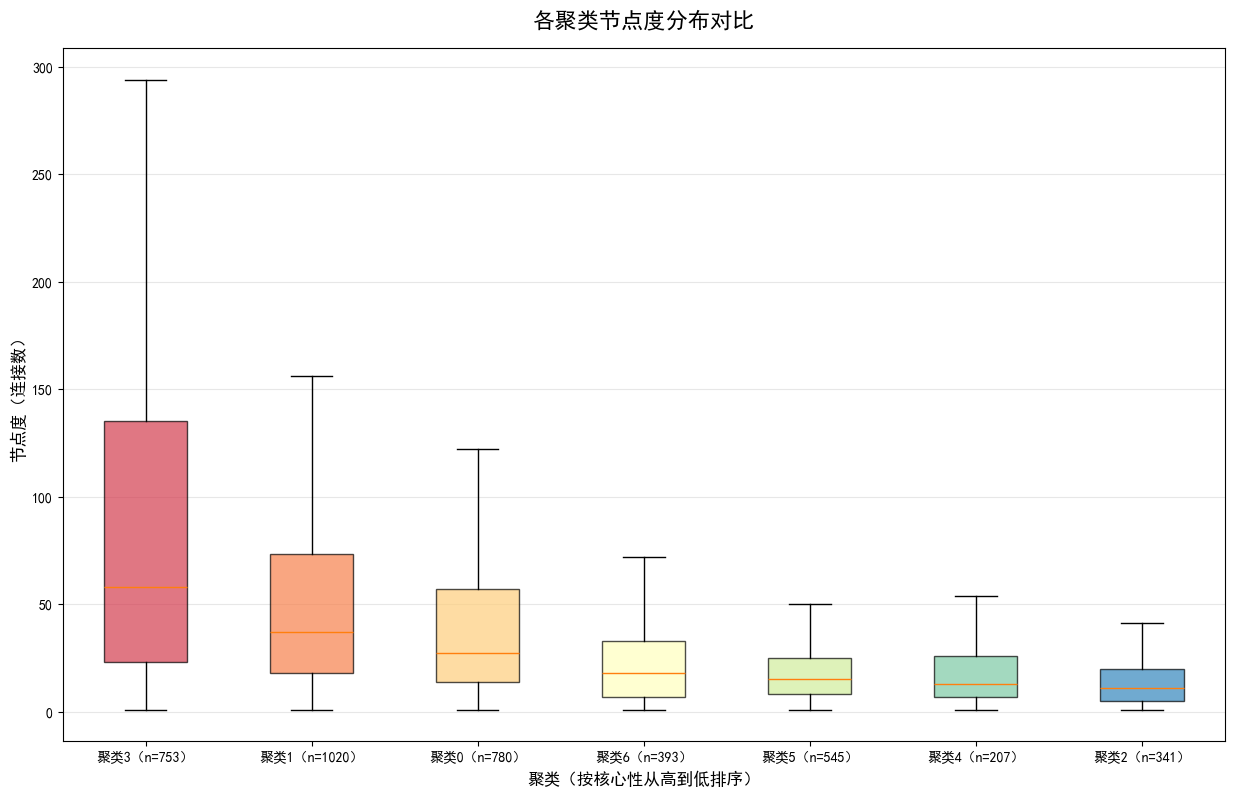

In [14]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.set_title("各聚类节点度分布对比", fontsize=16, pad=15)

cluster_degrees = []
cluster_labels_for_plot = []
for cluster_id in core_cluster_ids:
    cluster_degrees.append(node_degrees[cluster_labels == cluster_id])
    cluster_labels_for_plot.append(f'聚类{cluster_id}（n={len(cluster_degrees[-1])}）')

box_plot = ax.boxplot(
    cluster_degrees, labels=cluster_labels_for_plot, patch_artist=True,
    showfliers=False
)

for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xlabel("聚类（按核心性从高到低排序）", fontsize=12)
ax.set_ylabel("节点度（连接数）", fontsize=12)
ax.grid(axis='y', alpha=0.3)

In [19]:
def output_final_results(cluster_labels, core_cluster_ids, cluster_degree_stats):
    for idx, (cluster_id, stat) in enumerate(zip(core_cluster_ids, cluster_degree_stats)):
        print(f"{idx+1}. 聚类{cluster_id}:")
        print(f"   - 节点数: {stat['node_count']}（占比{stat['node_count']/len(cluster_labels):.2%}）")
        print(f"   - 核心性得分: {stat['core_score']:.2f}（相对平均度）")
        print(f"   - 节点度统计: 平均{stat['avg_degree']:.2f}，最大{stat['max_degree']}，最小{stat['min_degree']}")

    core_stat = cluster_degree_stats[0]
    edge_stat = cluster_degree_stats[-1]
    print(f"核心性差异: 核心聚类平均度是边缘聚类的{core_stat['avg_degree']/edge_stat['avg_degree']:.2f}倍")

output_final_results(cluster_labels, core_cluster_ids, cluster_degree_stats)

1. 聚类3:
   - 节点数: 753（占比18.64%）
   - 核心性得分: 1.87（相对平均度）
   - 节点度统计: 平均81.86，最大755，最小1
2. 聚类1:
   - 节点数: 1020（占比25.25%）
   - 核心性得分: 1.23（相对平均度）
   - 节点度统计: 平均53.84，最大1045，最小1
3. 聚类0:
   - 节点数: 780（占比19.31%）
   - 核心性得分: 0.86（相对平均度）
   - 节点度统计: 平均37.72，最大792，最小1
4. 聚类6:
   - 节点数: 393（占比9.73%）
   - 核心性得分: 0.59（相对平均度）
   - 节点度统计: 平均25.82，最大231，最小1
5. 聚类5:
   - 节点数: 545（占比13.49%）
   - 核心性得分: 0.45（相对平均度）
   - 节点度统计: 平均19.60，最大547，最小1
6. 聚类4:
   - 节点数: 207（占比5.13%）
   - 核心性得分: 0.44（相对平均度）
   - 节点度统计: 平均19.22，最大170，最小1
7. 聚类2:
   - 节点数: 341（占比8.44%）
   - 核心性得分: 0.38（相对平均度）
   - 节点度统计: 平均16.67，最大347，最小1
核心性差异: 核心聚类平均度是边缘聚类的4.91倍
